In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import utils as ut

# Mean field simulations

In [2]:
### Dot equations for the three variables to be passed to nsolve (in utils.py)

def mean_field_T_dot(var, pars):
    T, P, S = var
    return T * ( pars.mean_beta * P * max(0,1-S) - pars.gamma )

def mean_field_S_dot(var, pars):
    T, P, S = var
    if S >= 1: return 0
    return pars.mean_alpha * T

def mean_field_P_dot(var, pars):
    T, P, S = var
    return - P * ( pars.lambd * pars.mean_beta * max(0,(1-S)) * T + pars.mu )


### Constants 

def t_star_MHC_approx(pars, beta):
    r = pars.mean_beta * pars.P0 - pars.gamma
    return np.log( 1 + np.exp(pars.mu) * r / (pars.lambd*pars.mean_beta*pars.n) * np.log(beta*pars.P0/pars.gamma) ) / r

def t_star_S_approx(pars, beta, alpha):
    r = pars.mean_beta*pars.P0 - pars.gamma
    return np.log(r*(beta*pars.P0 - pars.gamma)/alpha/beta/pars.P0/pars.n) / r

def adim_var(pars, beta, alpha):
    return t_star_MHC_approx(pars, beta) / t_star_S_approx(pars, beta, alpha)
    #return alpha * beta * pars.P0 / pars.mean_beta / pars.lambd / (beta * pars.P0 - pars.gamma ) * np.log(beta*pars.P0/pars.gamma)

In [10]:
# Only one T cell with given tau
taus = [1]
lambd = 1e-3

# Four setting of parameters
# Default parameters with two values of alpha0 corresponding to the two regimes
pars_alpha = [ut.TT_params(taus, alpha0=1e-6, lambd=lambd), ut.TT_params(taus, alpha0=1e-2, lambd=lambd)]
# No ihibition case
pars_no_inhib = ut.TT_params(taus, alpha0=0, lambd=lambd)
# Non-antigen-depletion case
pars_no_depl = ut.TT_params(taus, lambd=0, mu=0, alpha0=pars_alpha[-1].alpha0)

# Initial conditions of mean field T, P and S 
init_vars = [1.0, pars_no_inhib.P0, 0.0]

# Dot equations for T, P and S
dot_eqs = [mean_field_T_dot, mean_field_P_dot, mean_field_S_dot]

# Integration paraemters
t_steps, dt, traj_steps = 5000, 0.02, 10

In [11]:
# Integrating each parameter setting

T_trajs_alpha, P_trajs_alpha, S_trajs_alpha = [], [], []
for pars in pars_alpha:
    trajs = np.array(ut.nsolve(init_vars, dot_eqs, pars, t_steps, dt, traj_steps))
    T_trajs_alpha.append(trajs[:,0])
    P_trajs_alpha.append(trajs[:,1])
    S_trajs_alpha.append(trajs[:,2])

trajs = np.array(ut.nsolve(init_vars, dot_eqs, pars_no_inhib, t_steps, dt, traj_steps))
T_trajs_no_inhib = trajs[:,0]
P_trajs_no_inhib = trajs[:,1]
S_trajs_no_inhib = trajs[:,2]

trajs = np.array(ut.nsolve(init_vars, dot_eqs, pars_no_depl, t_steps, dt, traj_steps))
T_trajs_no_depl = trajs[:,0]
P_trajs_no_depl = trajs[:,1]
S_trajs_no_depl = trajs[:,2]

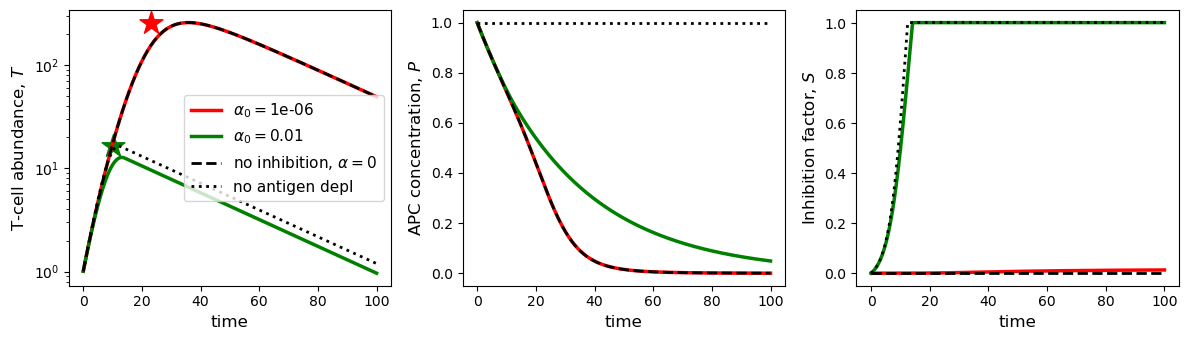

In [12]:
times = np.linspace(0, t_steps * dt, len(T_trajs_no_depl))
colors = ['r', 'g']

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,3.5))

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('time', fontsize=12)
    
ax1.set_ylabel('T-cell abundance, $T$', fontsize=12)
ax1.set_yscale('log')
for i, Ts in enumerate(T_trajs_alpha):
    ax1.plot(times, Ts, color=colors[i], lw=2.5, label=r'$\alpha_0=$%.g'%pars_alpha[i].alpha0)
ax1.plot(times, T_trajs_no_inhib, color='k', lw=2, ls='--', label=r'no inhibition, $\alpha=0$')
ax1.plot(times, T_trajs_no_depl, color='k', lw=2, ls=':', label=r'no antigen depl')
ax1.legend(fontsize=11)

b, a = pars_alpha[0].betas[0], pars_alpha[0].alphas[0]
ax1.scatter([t_star_MHC_approx(pars_alpha[0], b)], [np.max(T_trajs_no_inhib)], s=300, c='r', marker='*')
b, a = pars_alpha[1].betas[0], pars_alpha[1].alphas[0]
ax1.scatter([t_star_S_approx(pars_alpha[1], b, a)], [np.max(T_trajs_no_depl)], s=300, c='g', marker='*')


ax2.set_ylabel('APC concentration, $P$', fontsize=12)
for i, Ps in enumerate(P_trajs_alpha):
    ax2.plot(times, Ps, color=colors[i], lw=2.5)
ax2.plot(times, P_trajs_no_inhib, color='k', lw=2, ls='--')
ax2.plot(times, P_trajs_no_depl, color='k', lw=2, ls=':')

ax3.set_ylabel('Inhibition factor, $S$', fontsize=12)
for i, Ss in enumerate(S_trajs_alpha):
    ax3.plot(times, Ss, color=colors[i], lw=2.5)
ax3.plot(times, S_trajs_no_inhib, color='k', lw=2, ls='--')
ax3.plot(times, S_trajs_no_depl, color='k', lw=2, ls=':')

plt.tight_layout()

name = 'mean_field_dyn'
plt.savefig('plots/'+name+'.svg', dpi=200, facecolor='w')

pars_no_inhib.alpha0 = None # Alpha0 is not saved
pars_no_inhib.print_on_file('plots/', name+'_pars')